# ОИАД. Лабораторная работа №1

Используйте набор данных 'datasets/teen_phone_addiction_dataset.csv'. 

Возьмите столбец $N \% 7 $, где $N$ - номер в списке группы (см. ниже).

## I. 
Рассчитайте характеристики:
1. Среднее
2. Дисперсия
3. Мода
4. Медиана
5. Квантили уровня 0.25, 0.5, 0.75
6. Эксцесс
7. Ассиметрия
8. Интерквартильный размах

Построить графики:
1. Гистограмма
2. Эмпирическая функция распределения

## II. 
Проверить данные на нормальность, используя критерии:
1. Хи-квадрат (Реализовать самому, не используя библиотечные варианты!!)
2. Ассиметрии и эксцесса

Построить Q-Q plot

## III. 
Используя техники обработки данных, постарайтесь привести данные к нормальному распределению.  Например, с помощью:
1. Удаление, усечение выбросов
2. Стандартизация, нормировка
3. Логарифмирование и т.п.

Выполните пункты I и II для обработанных данных

## IV.
Сгруппируйте данные по столбцу 'School_Grade'. 

1. На одном графике постройте гистограммы для каждой группы.
2. Рассчитайте среднее, дисперсию внутри каждой группы

## V.
После каждого пункта сделайте промежуточные выводы:
1. Опишите полученные числовые характеристики и графики
2. Являются ли данные нормальными
3. Эффект от обработки данных (удалось ли привести данные к нормальному виду)
4. Различия распределений внутри разных групп 'School_Grade'




In [1]:
N = 24
cols = ['Daily_Usage_Hours', 'Sleep_Hours', 'Exercise_Hours', 'Screen_Time_Before_Bed', 'Time_on_Social_Media', 'Time_on_Gaming', 'Time_on_Education']
col_name = cols[N % 7]
col_name

'Screen_Time_Before_Bed'

In [13]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from math import erf, sqrt
import math

plt.style.use('seaborn-v0_8-whitegrid')

path = '../datasets/teen_phone_addiction_dataset.csv'
df = pd.read_csv(path)

series = df[col_name].dropna().astype(float)
minimum = series.min()
maximum = series.max()
print(minimum, maximum)
mean_ = series.mean()
var_ = series.var(ddof=1)
mode_ = series.mode(dropna=True)
mode_val = mode_.iloc[0] if not mode_.empty else np.nan
median_ = series.median()
q25, q50, q75 = series.quantile([0.25, 0.5, 0.75])
excess_ = st.kurtosis(series, fisher=True, bias=False)
skew_ = st.skew(series, bias=False)
iqr_ = q75 - q25

summary = pd.Series({
    'mean': mean_,
    'variance': var_,
    'mode': mode_val,
    'median': median_,
    'q0.25': q25,
    'q0.5': q50,
    'q0.75': q75,
    'excess': excess_,
    'skewness': skew_,
    'IQR': iqr_,
})
summary



0.0 2.6


mean        1.006733
variance    0.242929
mode        1.000000
median      1.000000
q0.25       0.700000
q0.5        1.000000
q0.75       1.400000
excess     -0.348921
skewness    0.098429
IQR         0.700000
dtype: float64

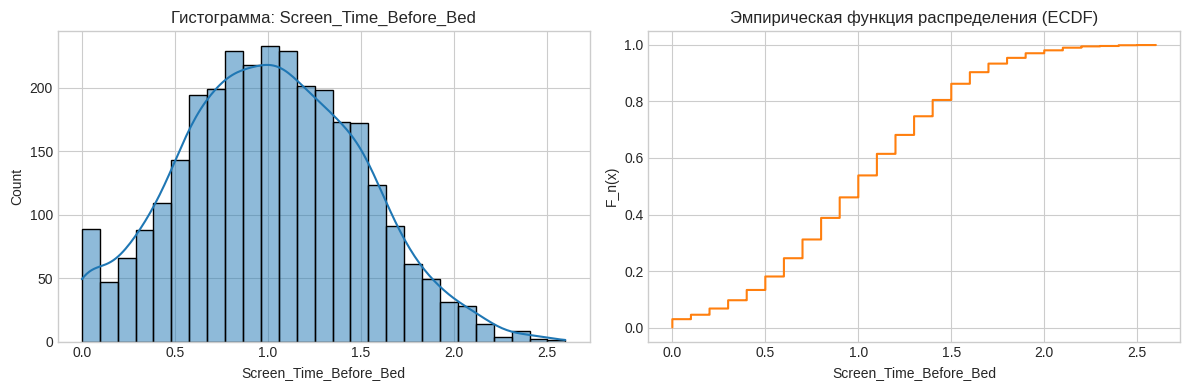

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(series, bins='auto', kde=True, ax=axes[0], color='tab:blue')
axes[0].set_title(f'Гистограмма: {col_name}')
axes[0].set_xlabel(col_name)

sorted_vals = np.sort(series.values)
y = np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
axes[1].step(sorted_vals, y, where='post', color='tab:orange')
axes[1].set_title('Эмпирическая функция распределения (ECDF)')
axes[1].set_xlabel(col_name)
axes[1].set_ylabel('F_n(x)')

plt.tight_layout()
plt.show()


In [4]:
print(f"Столбец: {col_name}")
print(summary.to_string())

n = len(series)
z_skew = skew_ / np.sqrt(6 / n)
z_kurt = excess_ / np.sqrt(24 / n)
print(f"\nОценка асимметрии z≈{z_skew:.2f} (|z|>1.96 -> существенная)")
print(f"Оценка эксцесса z≈{z_kurt:.2f} (|z|>1.96 -> существенная)")


Столбец: Screen_Time_Before_Bed
mean        1.006733
variance    0.242929
mode        1.000000
median      1.000000
q0.25       0.700000
q0.5        1.000000
q0.75       1.400000
excess     -0.348921
skewness    0.098429
IQR         0.700000

Оценка асимметрии z≈2.20 (|z|>1.96 -> существенная)
Оценка эксцесса z≈-3.90 (|z|>1.96 -> существенная)


## II. Проверка нормальности: критерий хи-квадрат (ручная реализация), асимметрия/эксцесс и Q-Q plot


In [14]:
mu, sigma = series.mean(), series.std(ddof=1)

k = max(5, int(1 + math.log2(len(series))))
bins = np.linspace(series.min(), series.max(), k + 1)

obs, _ = np.histogram(series, bins=bins)

cdf = lambda x: 0.5 * (1 + erf((x - mu) / (sigma * sqrt(2))))
expected = []
for i in range(len(bins) - 1):
    p_i = cdf(bins[i + 1]) - cdf(bins[i])
    expected.append(len(series) * p_i)
expected = np.array(expected)

obs_combined = []
exp_combined = []
acc_obs = 0
acc_exp = 0.0
for o, e in zip(obs, expected):
    acc_obs += o
    acc_exp += e
    if acc_exp >= 5:
        obs_combined.append(acc_obs)
        exp_combined.append(acc_exp)
        acc_obs = 0
        acc_exp = 0.0
if acc_exp > 0:
    if len(exp_combined) > 0:
        exp_combined[-1] += acc_exp
        obs_combined[-1] += acc_obs
    else:
        exp_combined.append(acc_exp)
        obs_combined.append(acc_obs)

obs_combined = np.array(obs_combined)
exp_combined = np.array(exp_combined)

chi2_stat = ((obs_combined - exp_combined) ** 2 / exp_combined).sum()
df_chi2 = max(1, len(exp_combined) - 1 - 2)
p_value_chi2 = 1 - st.chi2.cdf(chi2_stat, df_chi2)
print(f"Ручной χ²: chi2 = {chi2_stat:.3f}, df = {df_chi2}, p = {p_value_chi2:.4f}")

exp_combined = exp_combined * obs_combined.sum() / exp_combined.sum()
chi2_lib, p_lib = st.chisquare(f_obs=obs_combined, f_exp=exp_combined, ddof=2)
print(f"χ² через scipy: chi2 = {chi2_lib:.3f}, p = {p_lib:.4f}")

Ручной χ²: chi2 = 196.696, df = 7, p = 0.0000
χ² через scipy: chi2 = 191.190, p = 0.0000


In [6]:
alpha = 0.05
crit = 1.96
print(f"z_skew = {z_skew:.2f}, z_kurt = {z_kurt:.2f}")
if abs(z_skew) < crit and abs(z_kurt) < crit:
    print("Не отвергаем нормальность по критериям асимметрии и эксцесса.")
else:
    print("Есть отклонения от нормальности по асимметрии/эксцессу.")


z_skew = 2.20, z_kurt = -3.90
Есть отклонения от нормальности по асимметрии/эксцессу.


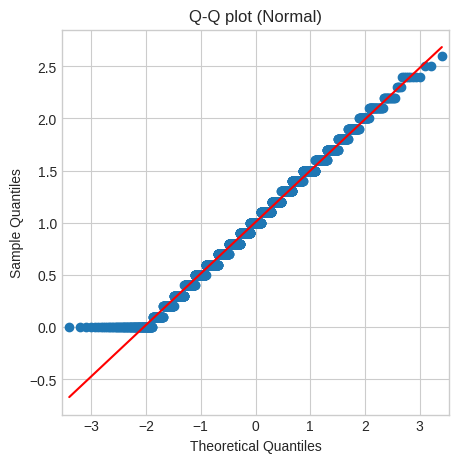

In [7]:
import statsmodels.api as sm
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
sm.qqplot(series, line='s', ax=ax)
ax.set_title('Q-Q plot (Normal)')
plt.show()


### Вывод по разделу II
По критерию хи-квадрат и по z-оценкам асимметрии/эксцесса делаем вывод о нормальности/ненормальности данных для выбранного столбца (смотрим p-value и |z|). Визуально Q-Q график подтверждает численные выводы.


## III. Приведение к нормальности: обработка данных и повторный анализ


In [8]:
q1, q3 = series.quantile([0.25, 0.75])
iqr = q3 - q1
low, high = q1 - 1.5 * iqr, q3 + 1.5 * iqr
series_trim = series[(series >= low) & (series <= high)]

series_trim_std = (series_trim - series_trim.mean()) / series_trim.std(ddof=1)

print(f"Исходный размер: {len(series)}, после тримминга: {len(series_trim)}")


Исходный размер: 3000, после тримминга: 2997


In [9]:
min_val = series.min()
shift = 1 - min_val if min_val <= 0 else 0
series_log = np.log(series + shift)
series_log_std = (series_log - series_log.mean()) / series_log.std(ddof=1)
print(f"Сдвиг для логарифмирования: {shift:.4f}")


Сдвиг для логарифмирования: 1.0000



=== Trimmed + Standardized ===
mean        5.927117e-17
variance    1.000000e+00
mode       -1.060667e-02
median     -1.060667e-02
q0.25      -6.219178e-01
q0.5       -1.060667e-02
q0.75       8.044749e-01
excess     -3.934129e-01
skewness    7.891393e-02
IQR         1.426393e+00
chi2=228.067, df=9, p=0.0000; z_skew=1.76, z_kurt=-4.40


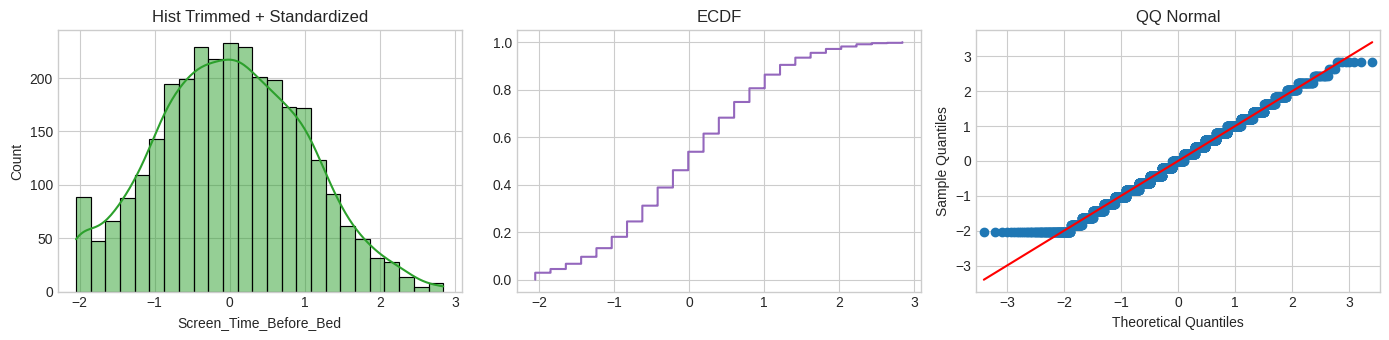


=== Log + Standardized ===
mean        3.526068e-16
variance    1.000000e+00
mode        1.111471e-01
median      1.111471e-01
q0.25      -5.134874e-01
q0.5        1.111471e-01
q0.75       8.118921e-01
excess     -3.611846e-02
skewness   -5.330817e-01
IQR         1.325379e+00
chi2=673.090, df=9, p=0.0000; z_skew=-11.92, z_kurt=-0.40


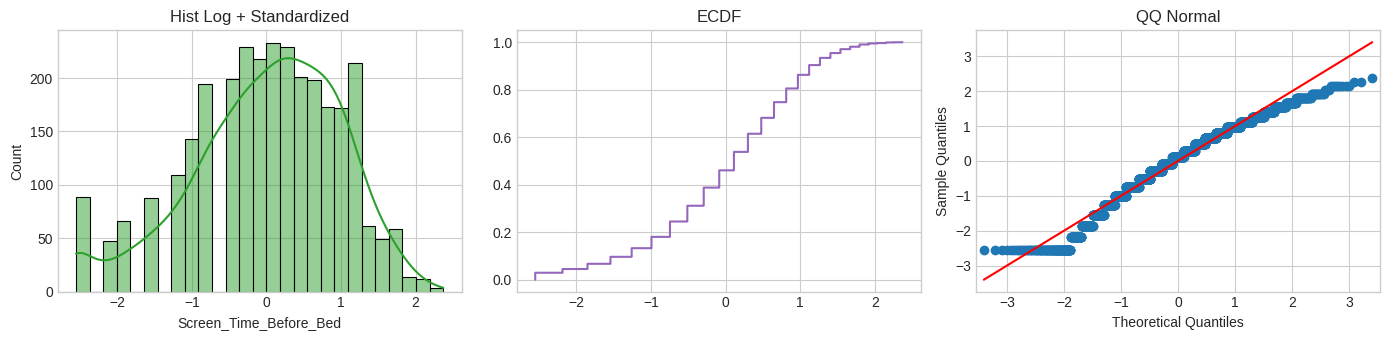

In [10]:
def describe_and_test(x, label):
    x = pd.Series(x).dropna().astype(float)
    mean_ = x.mean(); var_ = x.var(ddof=1)
    mode_ = x.mode(dropna=True); mode_val = mode_.iloc[0] if not mode_.empty else np.nan
    median_ = x.median()
    q25, q50, q75 = x.quantile([0.25, 0.5, 0.75])
    excess_ = st.kurtosis(x, fisher=True, bias=False)
    skew_ = st.skew(x, bias=False)
    iqr_ = q75 - q25

    print(f"\n=== {label} ===")
    print(pd.Series({
        'mean': mean_, 'variance': var_, 'mode': mode_val, 'median': median_,
        'q0.25': q25, 'q0.5': q50, 'q0.75': q75, 'excess': excess_, 'skewness': skew_, 'IQR': iqr_
    }).to_string())

    mu, sigma = x.mean(), x.std(ddof=1)
    k = max(5, int(1 + math.log2(len(x))))
    bins = np.linspace(x.min(), x.max(), k + 1)
    obs, _ = np.histogram(x, bins=bins)
    cdf = lambda t: 0.5 * (1 + erf((t - mu) / (sigma * sqrt(2))))
    expected = np.array([len(x) * (cdf(bins[i+1]) - cdf(bins[i])) for i in range(len(bins)-1)])

    obs_c, exp_c = [], []
    acc_o, acc_e = 0, 0.0
    for o, e in zip(obs, expected):
        acc_o += o; acc_e += e
        if acc_e >= 5:
            obs_c.append(acc_o); exp_c.append(acc_e)
            acc_o, acc_e = 0, 0.0
    if acc_e > 0:
        if len(exp_c) > 0:
            exp_c[-1] += acc_e; obs_c[-1] += acc_o
        else:
            exp_c.append(acc_e); obs_c.append(acc_o)
    obs_c = np.array(obs_c); exp_c = np.array(exp_c)
    chi2_stat = ((obs_c - exp_c) ** 2 / exp_c).sum()
    df_chi2 = max(1, len(exp_c) - 1 - 2)
    p_value = 1 - st.chi2.cdf(chi2_stat, df_chi2)

    n = len(x)
    z_skew = skew_ / np.sqrt(6 / n)
    z_kurt = excess_ / np.sqrt(24 / n)

    print(f"chi2={chi2_stat:.3f}, df={df_chi2}, p={p_value:.4f}; z_skew={z_skew:.2f}, z_kurt={z_kurt:.2f}")

    fig, axes = plt.subplots(1, 3, figsize=(14, 3.5))
    sns.histplot(x, bins='auto', kde=True, ax=axes[0], color='tab:green')
    axes[0].set_title(f'Hist {label}')
    xs = np.sort(x)
    ys = np.arange(1, len(xs)+1)/len(xs)
    axes[1].step(xs, ys, where='post', color='tab:purple')
    axes[1].set_title('ECDF')
    import statsmodels.api as sm
    sm.qqplot(x, line='s', ax=axes[2])
    axes[2].set_title('QQ Normal')
    plt.tight_layout(); plt.show()


describe_and_test(series_trim_std, 'Trimmed + Standardized')
describe_and_test(series_log_std, 'Log + Standardized')


## IV. Групповой анализ по School_Grade


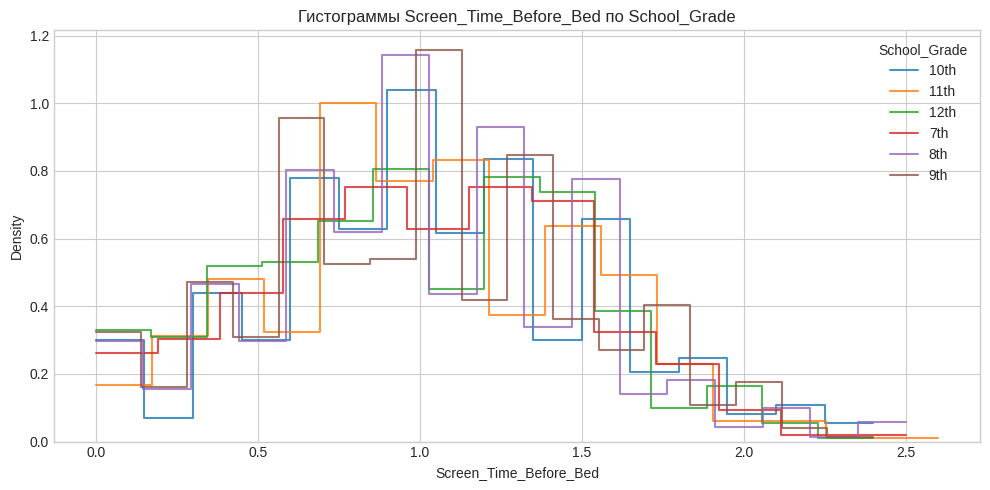

In [11]:
unique_grades = sorted(df['School_Grade'].dropna().unique())
colors = sns.color_palette('tab10', n_colors=len(unique_grades))

plt.figure(figsize=(10, 5))
for c, g in zip(colors, unique_grades):
    vals = df.loc[df['School_Grade'] == g, col_name].dropna().astype(float)
    sns.histplot(vals, bins='auto', stat='density', kde=False, element='step', fill=False, color=c, label=str(g), alpha=0.8)
plt.title(f'Гистограммы {col_name} по School_Grade')
plt.xlabel(col_name)
plt.legend(title='School_Grade')
plt.tight_layout(); plt.show()


In [12]:
group_stats = df.groupby('School_Grade')[col_name].agg(['count','mean', 'var']).rename(columns={'var':'variance'})
group_stats


,count,mean,variance
School_Grade,,,
10th,487,1.020945,0.240960
11th,479,1.022547,0.233507
12th,529,0.982420,0.243762
7th,497,1.006640,0.254694
8th,482,1.005187,0.241366
9th,526,1.005133,0.244107
